In [4]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import scipy.interpolate as sciint
from scipy.signal import savgol_filter
import mne
import pywt
from scipy.signal import butter, filtfilt


# 1. Download and Explore the Dataset

In [5]:
# Load electrodes informations
n,arg,module,electrode_names = np.loadtxt("./Data/Coordinates.locs", dtype=[('col1', int), ('col2', float), ('col3', float), ('col4', 'U4')], unpack=True)

x = -module * np.cos(np.radians(arg+90))  # If arg is in degrees
y = module * np.sin(np.radians(arg+90))

Define parameters

In [6]:
sampling_rate = 128 #Hz
n_samples = 3200
sampling_duration = 25
time = np.linspace(0, sampling_duration, n_samples)
n_channels = 32
FMIN, FMAX = 0.5, 50 #Hz

Colonnes retenues (tâches + trials) :
MultiIndex([('Trial_1',    'Maths'),
            ('Trial_1', 'Symmetry'),
            ('Trial_1',   'Stroop'),
            ('Trial_2',    'Maths'),
            ('Trial_2', 'Symmetry'),
            ('Trial_2',   'Stroop'),
            ('Trial_3',    'Maths'),
            ('Trial_3', 'Symmetry'),
            ('Trial_3',   'Stroop')],
           )
Nombre total de valeurs de stress valides : 360


C:\Users\gaspa\AppData\Local\Temp\ipykernel_2988\4132195343.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  all_stress_values = scales_df.stack(level=[0, 1]).values.flatten()


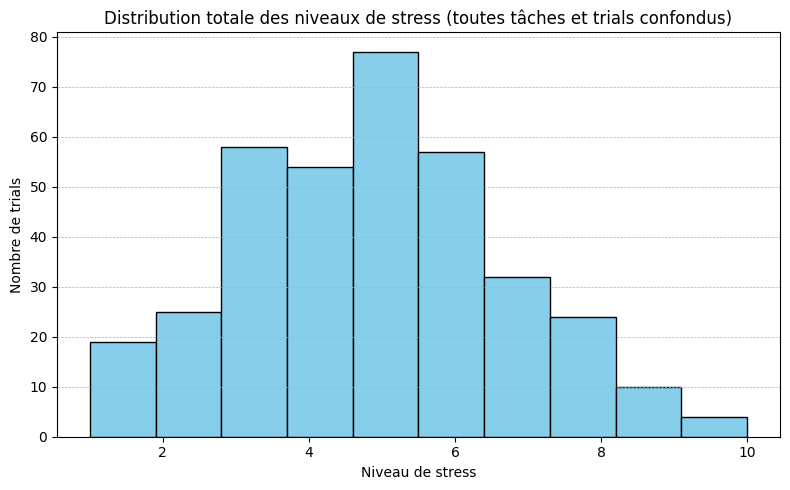

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier Excel avec double en-tête, mais en ignorant la première colonne (IDs)
scales_df = pd.read_excel('./Data/scales.xls', header=[0, 1])

# Supprimer la première colonne (identifiants des sujets)
# Si ton fichier a un index classique (0,1,2...) alors la première vraie colonne est scales_df.columns[0]
scales_df = scales_df.iloc[:, 1:]

print("Colonnes retenues (tâches + trials) :")
print(scales_df.columns)

# Aplatir le tableau (toutes tâches + tous trials)
all_stress_values = scales_df.stack(level=[0, 1]).values.flatten()

# Nettoyer les données
all_stress_values = pd.Series(all_stress_values).dropna()

print(f"Nombre total de valeurs de stress valides : {len(all_stress_values)}")

# Plot de la distribution totale
plt.figure(figsize=(8, 5))
plt.hist(all_stress_values, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution totale des niveaux de stress (toutes tâches et trials confondus)")
plt.xlabel("Niveau de stress")
plt.ylabel("Nombre de trials")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 2. Perform Exploratory Data Analysis (EDA)

##### Load EEG data

In [8]:
R_Arithmetic_sub_17_trial1 = loadmat('./Data/raw_data/Arithmetic_sub_17_trial1.mat')
R_Arithmetic_sub_17_trial1 = R_Arithmetic_sub_17_trial1['Data']

F_Arithmetic_sub_17_trial1 = loadmat('./Data/filtered_data/Arithmetic_sub_17_trial1.mat')
F_Arithmetic_sub_17_trial1 = F_Arithmetic_sub_17_trial1['Clean_data']


## Time plotting

#### Plot raw data

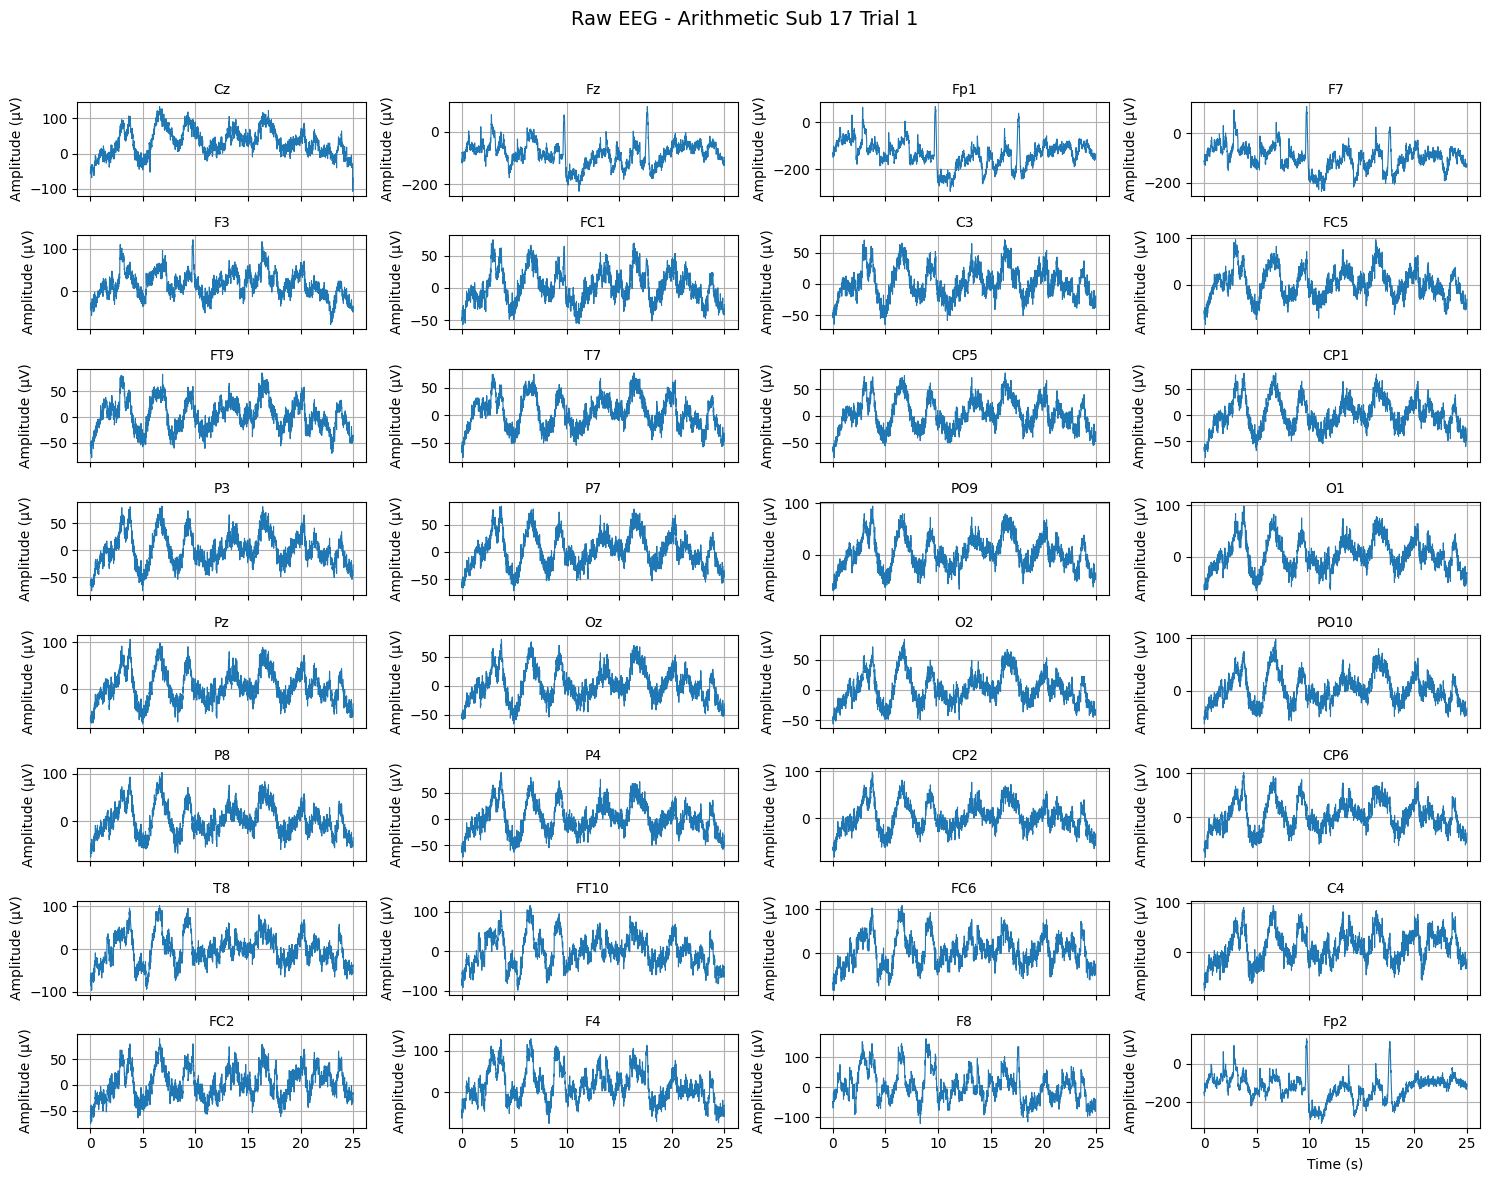

In [9]:
# Plot them
fig, axes = plt.subplots(8, 4, figsize=(15, 12), sharex=True)
fig.suptitle("Raw EEG - Arithmetic Sub 17 Trial 1", fontsize=14)


for i, ax in enumerate(axes.flat):
    if i < n_channels:  
        ax.plot(time, R_Arithmetic_sub_17_trial1[i, :], linewidth=0.8)
        ax.set_title(electrode_names[i], fontsize=10)
        ax.set_ylabel("Amplitude (µV)")
        ax.grid(True)

# Display
plt.xlabel("Time (s)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

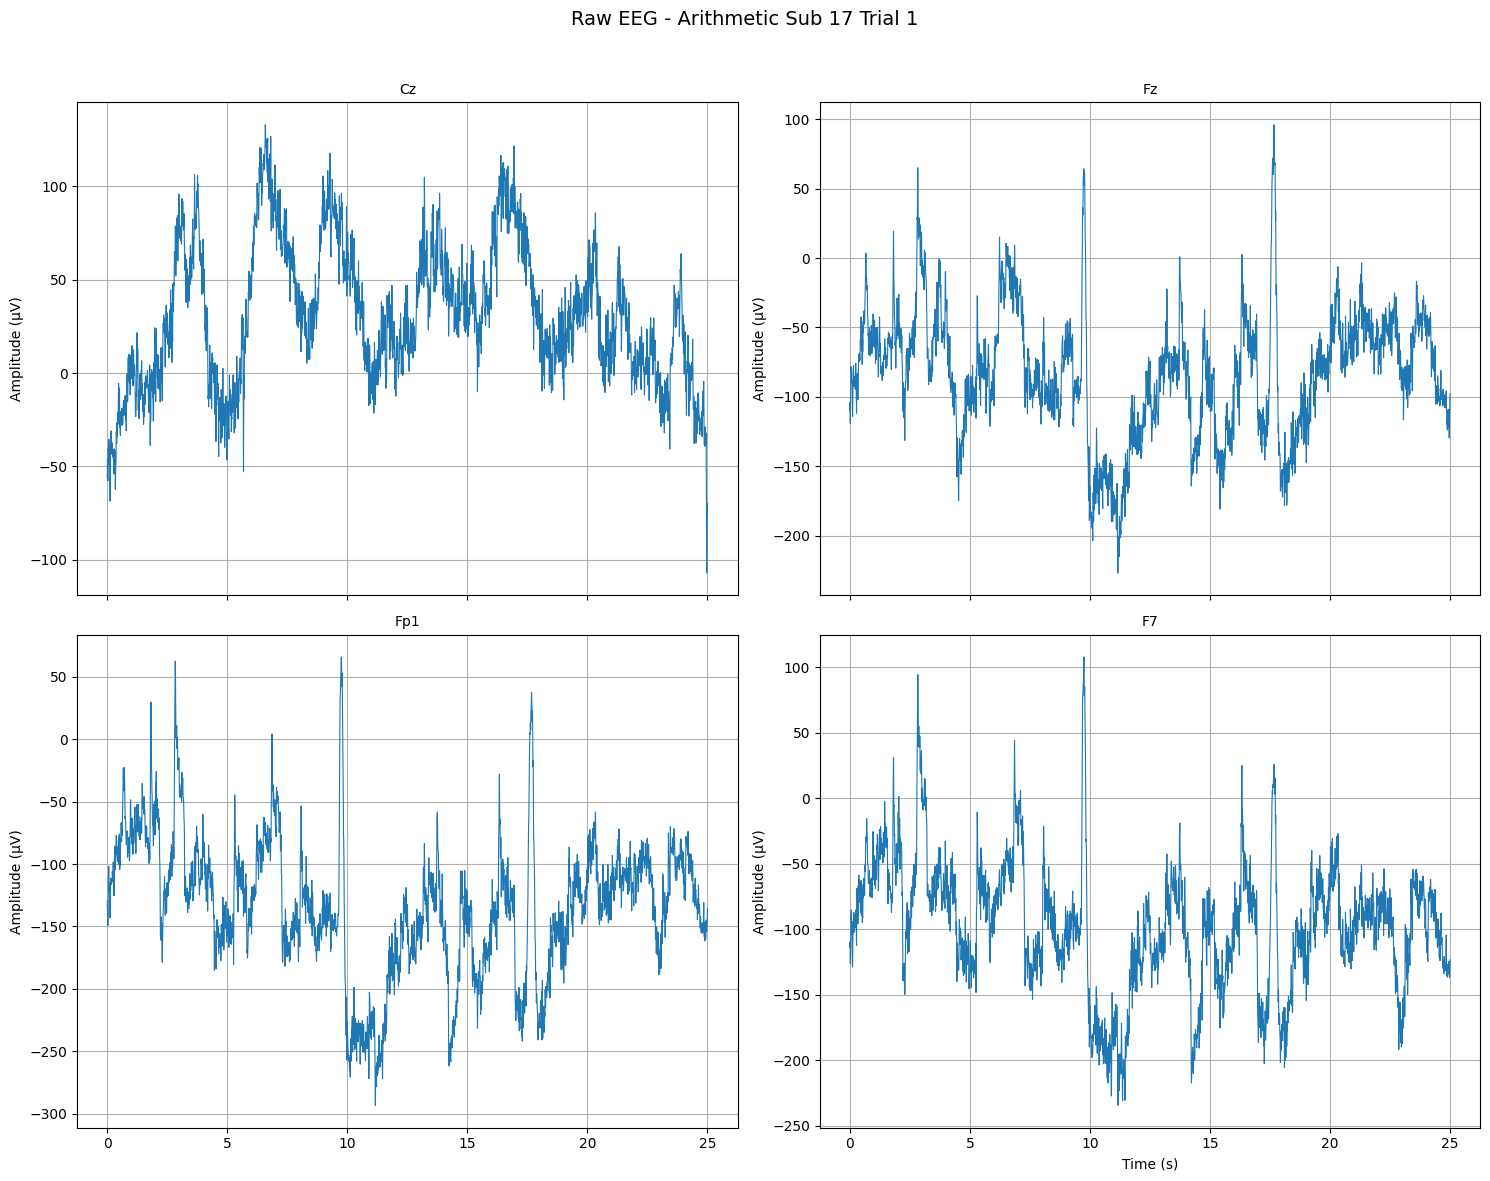

In [10]:
# Plot 4 of them
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
fig.suptitle("Raw EEG - Arithmetic Sub 17 Trial 1", fontsize=14)


for i, ax in enumerate(axes.flat):
    if i < 4:  
        ax.plot(time, R_Arithmetic_sub_17_trial1[i, :], linewidth=0.8)
        ax.set_title(electrode_names[i], fontsize=10)
        ax.set_ylabel("Amplitude (µV)")
        ax.grid(True)

# Display
plt.xlabel("Time (s)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

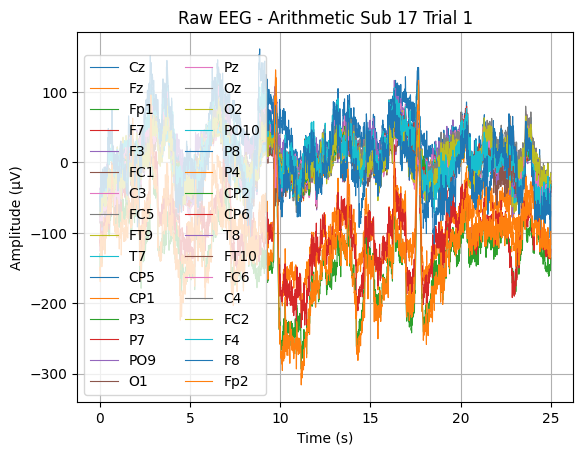

In [11]:
for i in range(32):
    plt.plot(time, R_Arithmetic_sub_17_trial1[i, :], linewidth=0.8,label=electrode_names[i])

plt.legend(ncol=2)
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.xlabel("Time (s)")
plt.title("Raw EEG - Arithmetic Sub 17 Trial 1")
plt.show()

#### Plot filtered data

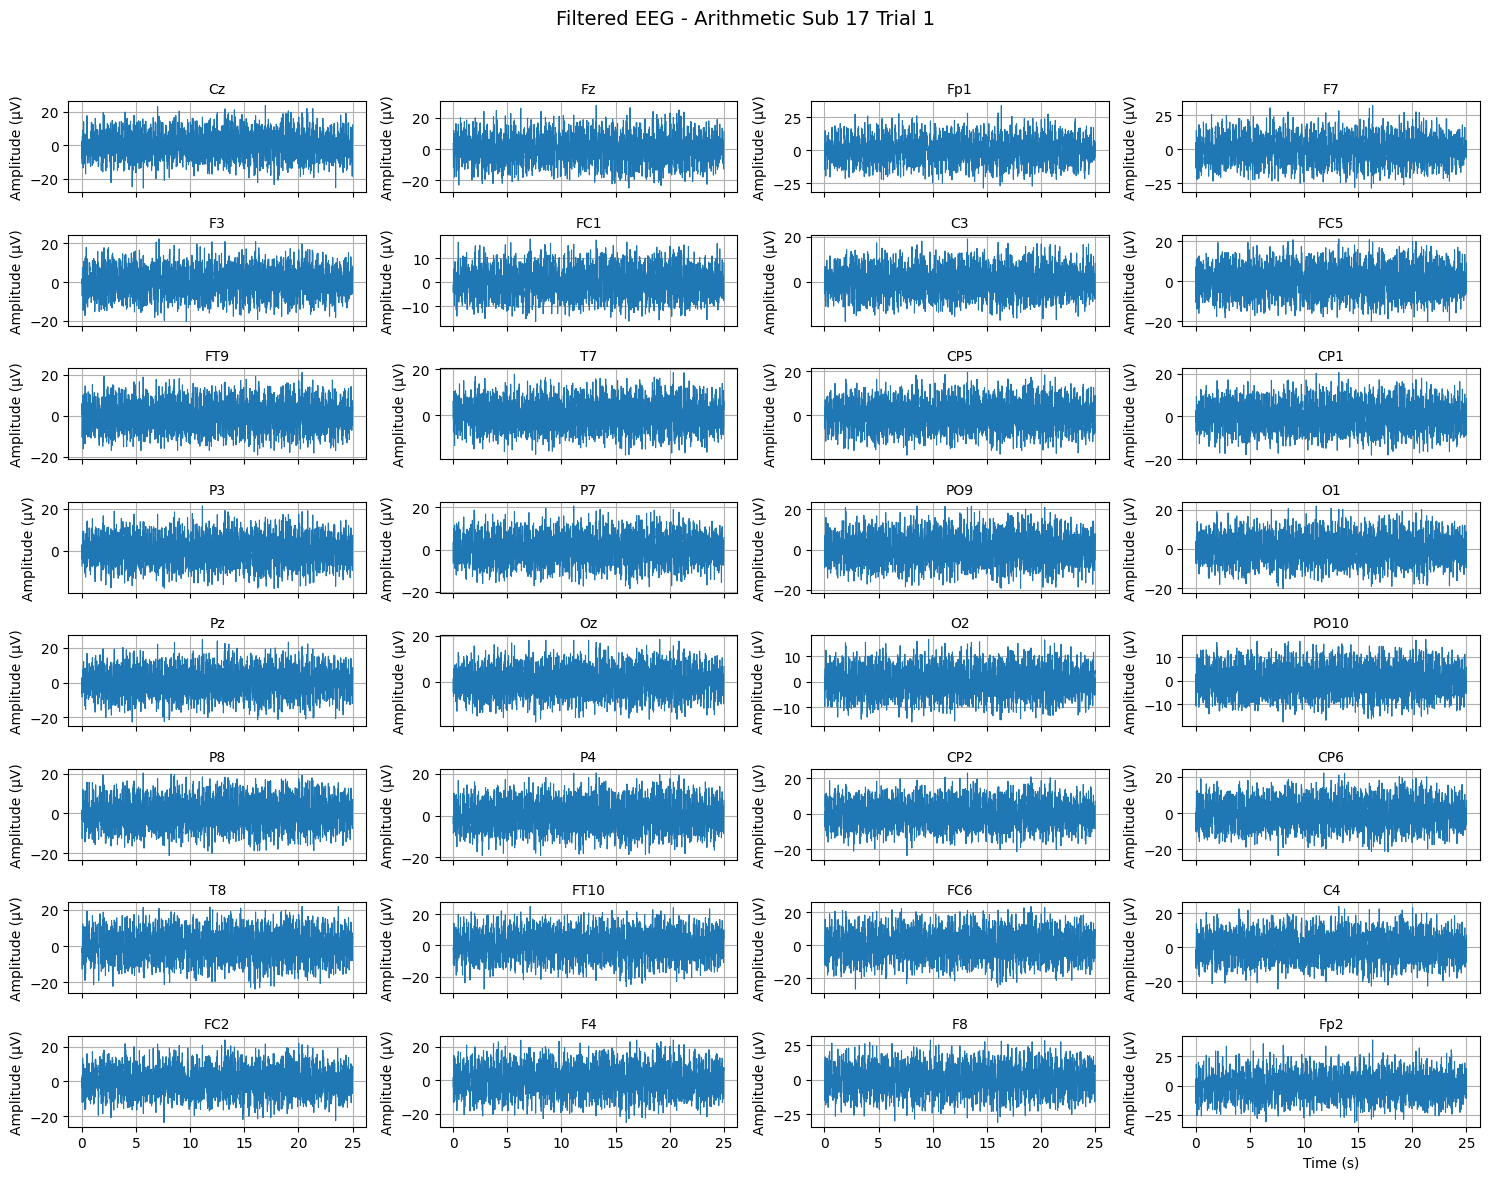

In [12]:
# Plot them
fig, axes = plt.subplots(8, 4, figsize=(15, 12), sharex=True)
fig.suptitle("Filtered EEG - Arithmetic Sub 17 Trial 1", fontsize=14)


for i, ax in enumerate(axes.flat):
    if i < n_channels:  
        ax.plot(time, F_Arithmetic_sub_17_trial1[i, :], linewidth=0.8)
        ax.set_title(electrode_names[i], fontsize=10)
        ax.set_ylabel("Amplitude (µV)")
        ax.grid(True)

# Display
plt.xlabel("Time (s)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

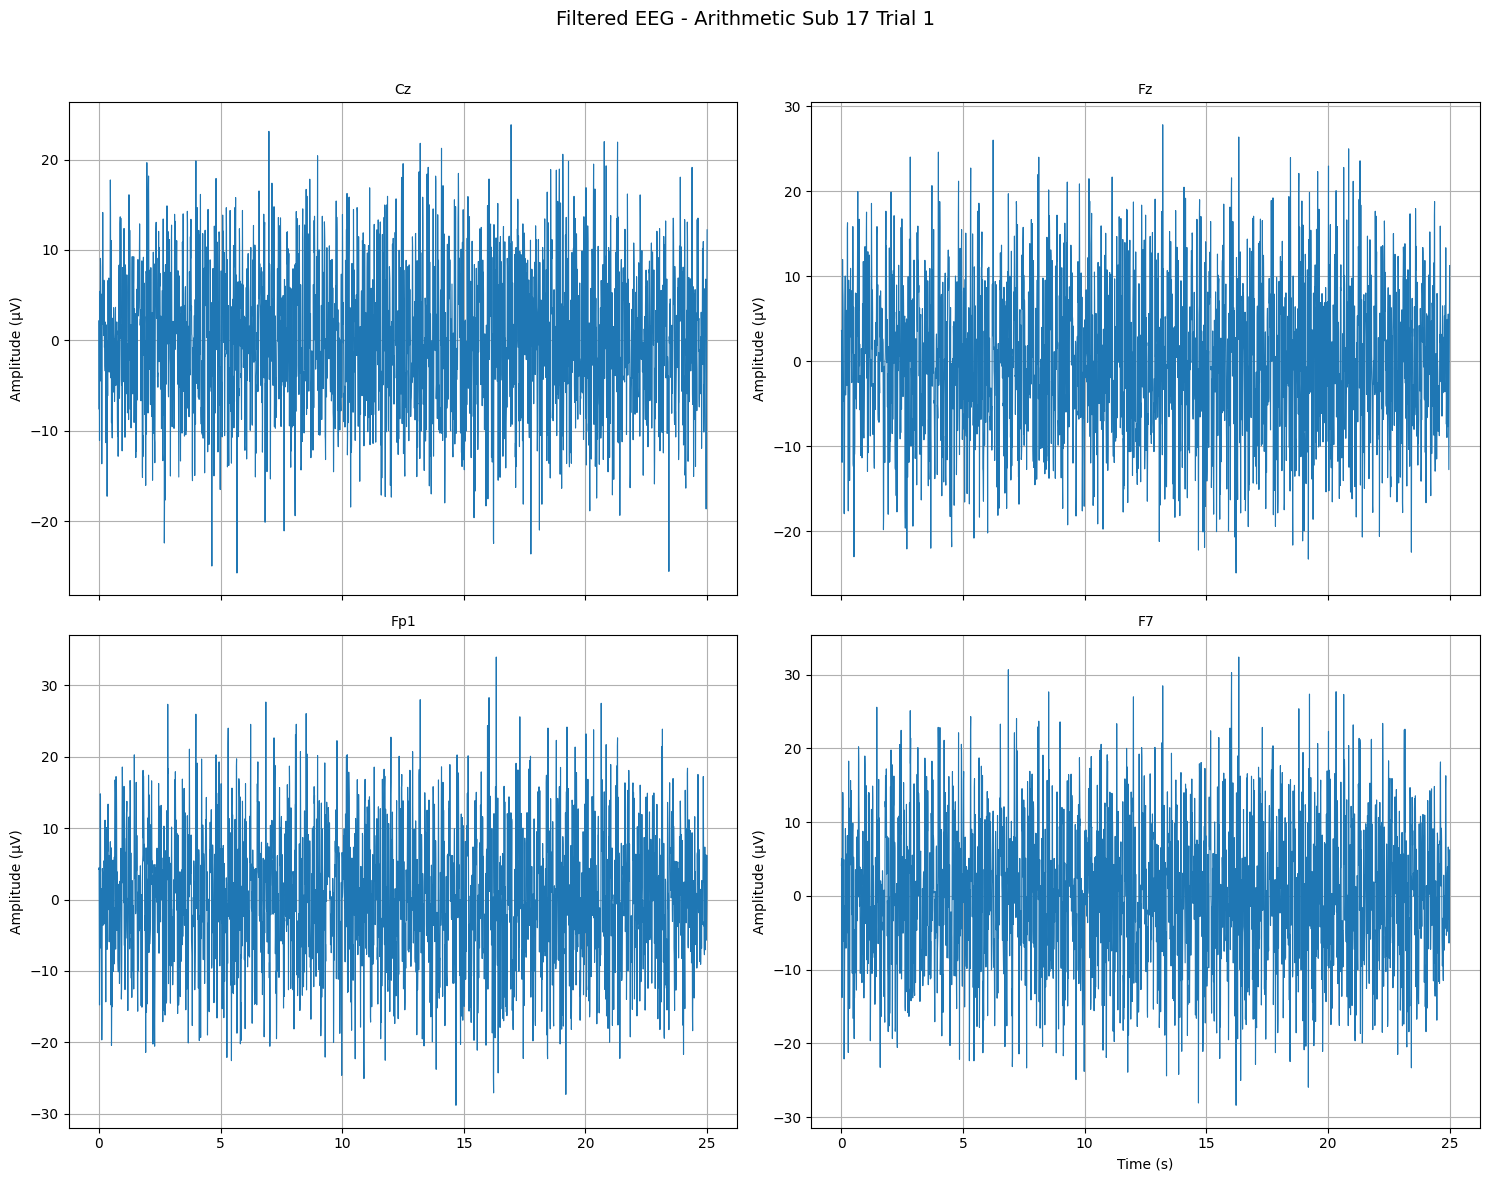

In [13]:
# Plot 4 of them
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
fig.suptitle("Filtered EEG - Arithmetic Sub 17 Trial 1", fontsize=14)


for i, ax in enumerate(axes.flat):
    if i < 4:  
        ax.plot(time, F_Arithmetic_sub_17_trial1[i, :], linewidth=0.8)
        ax.set_title(electrode_names[i], fontsize=10)
        ax.set_ylabel("Amplitude (µV)")
        ax.grid(True)

# Display
plt.xlabel("Time (s)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

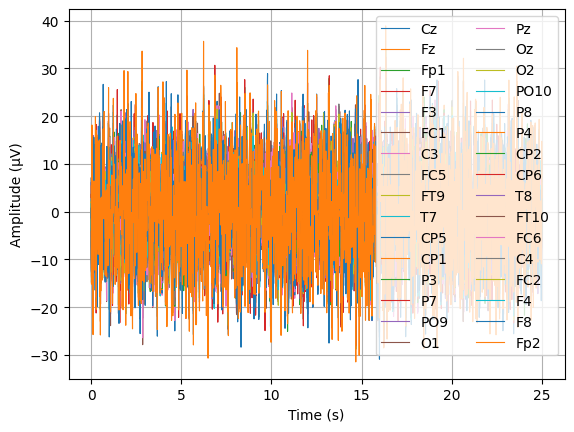

In [14]:
for i in range(32):
    plt.plot(time, F_Arithmetic_sub_17_trial1[i, :], linewidth=0.8,label=electrode_names[i])

plt.legend(ncol=2)
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.xlabel("Time (s)")
plt.show()

## Fourier analysis

#### FFT Plotting

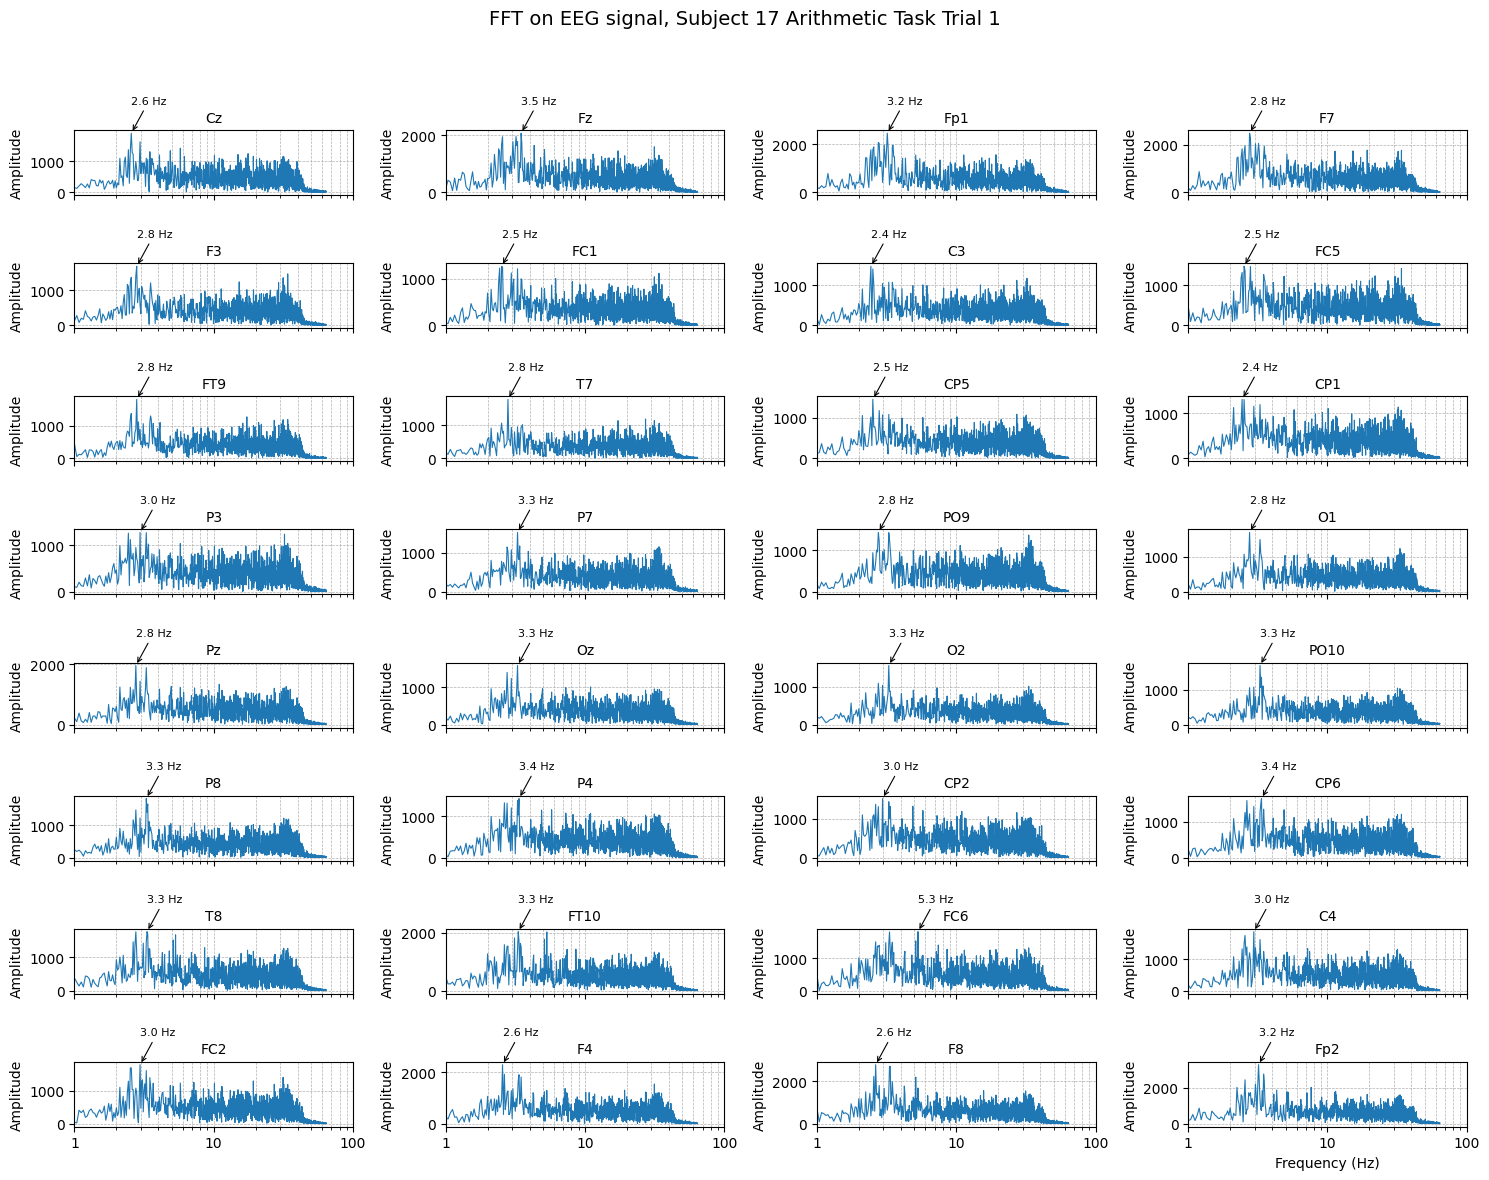

<Figure size 640x480 with 0 Axes>

In [15]:
freqs = np.fft.fftfreq(n_samples, d=1/sampling_rate)  # Frequency associated to each FFT point
positive_freqs = freqs[:n_samples // 2]  # Keep only positive frequencies

# FFT calculus
fft_data = np.fft.fft(F_Arithmetic_sub_17_trial1, axis=1)  # Fast Fourier Transform on each channel
power_spectrum = np.abs(fft_data)[:, :n_samples // 2]  # Power spectrum (modulus)

# Subplotting
fig, axes = plt.subplots(8, 4, figsize=(15, 12), sharex=True)
fig.suptitle("FFT on EEG signal, Subject 17 Arithmetic Task Trial 1", fontsize=14)

# Plotting spectrum
for i, ax in enumerate(axes.flat):
    if i < n_channels:
        ax.plot(positive_freqs, power_spectrum[i], linewidth=0.8)
        ax.set_title(electrode_names[i], fontsize=10)
        ax.set_ylabel("Amplitude")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.set_xscale("log")  # Échelle logarithmique en fréquence
        ax.set_xlim(1, sampling_rate / 2)  # Frequency between 1Hz and max according to Nyquist-Shannon criteria (64 Hz)
        ax.set_xticks([1, 10, 100])  
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        
        # Peak detection
        peak_idx = np.argmax(power_spectrum[i])  # Max frequency index
        peak_freq = positive_freqs[peak_idx]  # Corresponding frequency
        peak_amp = power_spectrum[i][peak_idx]  # Amplitude value
        
        ax.annotate(f"{peak_freq:.1f} Hz", 
                    xy=(peak_freq, peak_amp), 
                    xytext=(peak_freq, peak_amp * 1.5),
                    arrowprops=dict(arrowstyle="->", lw=0.8), fontsize=8)

plt.xlabel("Frequency (Hz)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

plt.savefig("fft_s1_arithmetric_t1.png")

## Topographic map

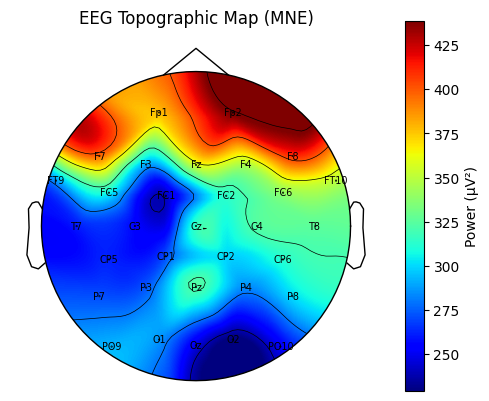

In [16]:
mean_power = power_spectrum.mean(axis=1)

# 1) MNE montage from your 2D coordinates (z=0)
x_pos = np.asarray(x, float).ravel()
y_pos = np.asarray(y, float).ravel()
ch_names = list(electrode_names)

assert len(ch_names) == x_pos.size == y_pos.size, "x/y/names: inconsistent sizes"

positions_3d = np.c_[x_pos, y_pos, np.zeros_like(x_pos)]
ch_pos = dict(zip(ch_names, positions_3d))

montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
info = mne.create_info(ch_names=ch_names, sfreq=float(sampling_rate), ch_types=['eeg'] * len(ch_names))
info.set_montage(montage, match_case=False)

# 2) Color scale (simple: min/max of this map)
vmin = float(np.nanmin(mean_power))
vmax = float(np.nanmax(mean_power))

# 3) 'sphere' for a clean head outline (radius ≈ extent of your coords)
r_est = float(np.nanmax(np.sqrt(x_pos**2 + y_pos**2)))
r_est = 1.05 * r_est if r_est > 0 else 0.1
sphere = (0.0, 0.0, 0.0, r_est)

# 4) MNE plot (with head mask)
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
ax.axis("off")

im, _ = mne.viz.plot_topomap(
    mean_power,
    info,
    axes=ax,
    cmap='jet',
    show=False,
    contours=6,
    sensors=True,
    names=ch_names,
    vlim = (vmin, vmax),      # consistent scale
    image_interp='cubic',
    extrapolate='head',
    outlines='head',
    sphere=sphere
)

# Colorbar
sm = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap='jet')
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.8, label="Power (µV²)")

ax.set_title("EEG Topographic Map (MNE)")
plt.show()


## Task-specific

#### Import data

In [17]:
# Import data
subject_number = 17
trial_number = 1
tasks_list = ['Arithmetic','Mirror_image','Relax','Stroop']
data = dict()

for task in tasks_list:
    filename = f'{task}_sub_{subject_number}_trial{trial_number}'
    path = f'./Data/filtered_data/{filename}.mat'
    file = loadmat(path)
    data[filename] = file['Clean_data']

#### Plot EEGs for 1 channel

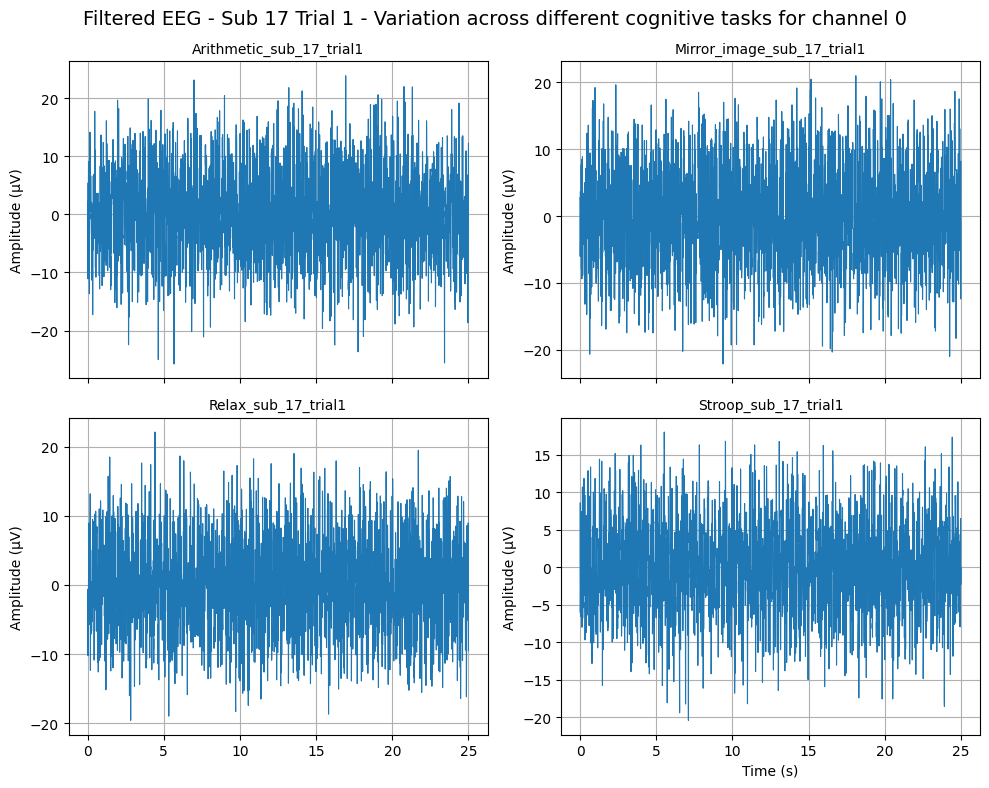

In [18]:
channel = 0

# Plot them
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
fig.suptitle(f"Filtered EEG - Sub {subject_number} Trial {trial_number} - Variation across different cognitive tasks for channel {channel}", fontsize=14)

# Iterate over tasks and subplots
for ax, (key, eeg_signal) in zip(axes.flatten(), data.items()):
    ax.plot(time, eeg_signal[channel, :], linewidth=0.8)  # Channel 0
    ax.set_title(key, fontsize=10)
    ax.set_ylabel("Amplitude (µV)")
    ax.grid(True)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

#### Plot topographic map to compare

We have to generate the mean power for each task. We can use the previous created 'positive_freqs'

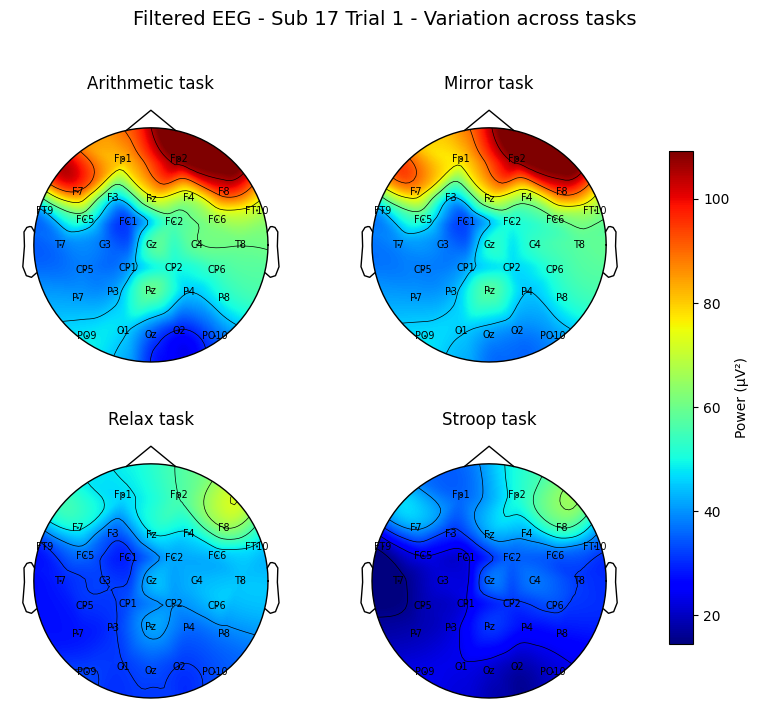

In [19]:
# --------------------------------------------
# 0) Create info and apply montage
# --------------------------------------------
ch_names = list(electrode_names)
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

# 3D positions (z=0)
positions_3d = np.column_stack((x, y, np.zeros_like(x)))
ch_pos = {name: pos for name, pos in zip(ch_names, positions_3d)}

montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')

# Check for name correspondence
missing_in_info = set(montage.ch_names) - set(info['ch_names'])
missing_in_montage = set(info['ch_names']) - set(montage.ch_names)
if missing_in_info or missing_in_montage:
    print("WARNING: Unmatched names")
    print("  In montage but not in info:", missing_in_info)
    print("  In info but not in montage:", missing_in_montage)

# Apply montage BEFORE any plot
info.set_montage(montage, match_case=False)

# --------------------------------------------
# 1) Prepare an explicit 'sphere' for outlines='head'
#    (avoids error if no digitization/fiducials)
# --------------------------------------------
# Estimated radius from your 2D coordinates
r_est = float(np.nanmax(np.sqrt(x**2 + y**2)))
# Slight margin
r_est = 1.05 * r_est if r_est > 0 else 0.1
sphere = (0.0, 0.0, 0.0, r_est)

# --------------------------------------------
# 2) FFT calculations -> |FFT|^2 and global vmin/vmax
# --------------------------------------------
z_data = {}
all_mean_powers = []

for key, eeg_signal in data.items():
    eeg_signal = eeg_signal - eeg_signal.mean(axis=1, keepdims=True)
    N = eeg_signal.shape[1]
    Fs = sampling_rate
    df = Fs / N
    f = np.fft.rfftfreq(N, d=1/Fs)

    X = np.fft.rfft(eeg_signal, axis=1)
    # PSD one-sided en µV²/Hz (Parseval OK):
    psd = (np.abs(X)**2) / (Fs * N)
    if N % 2 == 0:
        psd[:, 1:-1] *= 2
    else:
        psd[:, 1:] *= 2

    band = (f >= FMIN) & (f <= FMAX)
    mean_power = psd[:, band].sum(axis=1) * df       # µV²

    z_data[key] = mean_power
    all_mean_powers.append(mean_power)


all_vals = np.concatenate(all_mean_powers)
vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

# --------------------------------------------
# 3) MNE topomap plot with head mask + explicit sphere
# --------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(
    f"Filtered EEG - Sub {subject_number} Trial {trial_number} - Variation across tasks",
    fontsize=14
)

topomap_imgs = []

for ax, (key, mean_power) in zip(axes.flatten(), z_data.items()):
    ax.set_aspect('equal')
    ax.axis("off")

    im, _ = mne.viz.plot_topomap(
        mean_power,
        info,
        axes=ax,
        cmap='jet',
        show=False,
        contours=6,
        sensors=True,
        names=electrode_names,
        vlim= (vmin, vmax),   # common scale
        image_interp='cubic',
        extrapolate='head',
        outlines='head',
        sphere=sphere
    )

    ax.set_title(f"{key.split('_')[0]} task")
    topomap_imgs.append(im)

# -----------------------
# 3) Consistent shared colorbar
# -----------------------
sm = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap='jet')
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=axes.ravel().tolist(),
    shrink=0.8,
    label="Power (µV²)"
)

plt.show()


# 3. Perform Basic EEG data analysis

## Band Power Calculation

Beta &nbsp;	13–30 Hz &nbsp;	Focus, active thinking, task engagement. \
Theta &nbsp; 4–8 Hz	 &nbsp; Working memory, mental calculations, cognitive effort. \
Alpha &nbsp; 8–13 Hz &nbsp;	Mild relaxation, can decrease during intense focus.\
Delta &nbsp; 0.5–4 Hz &nbsp; Least relevant for math, linked to deep sleep and unconscious processes.\

In [20]:

from scipy.signal import welch

channel_names = [
    "Cz", "Fz", "Fp1", "F7", "F3", "FC1", "C3", "FC5", "FT9", "T7",
    "CP5", "CP1", "P3", "P7", "PO9", "O1", "Pz", "Oz", "O2", "PO10",
    "P8", "P4", "CP2", "CP6", "T8", "FT10", "FC6", "C4", "FC2", "F4",
    "F8", "Fp2"
]

# Define EEG frequency bands
bands = {
    "Delta (0.5-4 Hz)": (0.5, 4),
    "Theta (4-8 Hz)": (4, 8),
    "Alpha (8-12 Hz)": (8, 12),
    "Beta (12-30 Hz)": (12, 30),
    "Gamma (30-50 Hz)": (30, 50)
}

# Relevant channels based on task
task_channels = ['Fz', 'Cz', 'Pz', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4']  # For math exercises
relax_channels = ['Pz', 'O1', 'O2', 'Oz']  # For relaxation
all_channels = channel_names

# Subjects, Tasks & Trials
subjects = range(1, 41)
trials = range(1, 4)
tasks_list = ['Arithmetic', 'Mirror_image', 'Relax', 'Stroop']

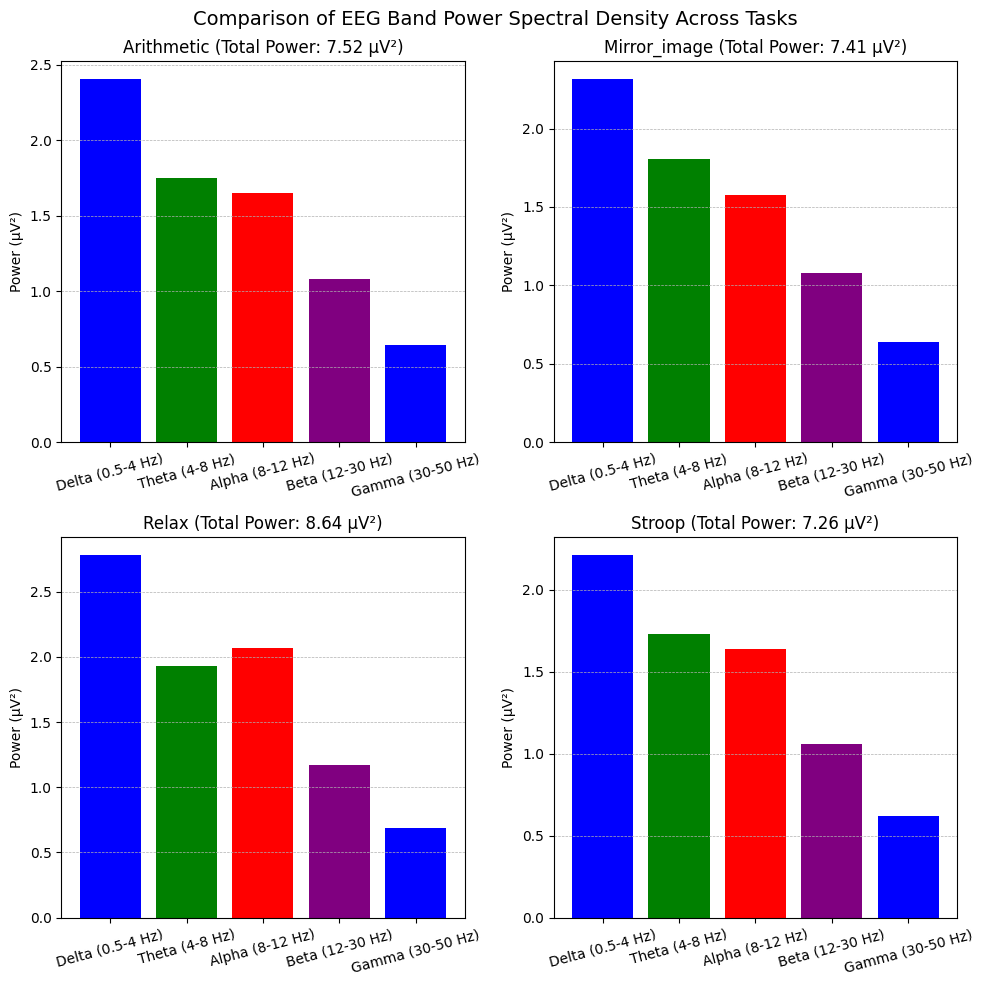

In [21]:
# Select which to use
selected_channels = task_channels  # relax_channels/task_channels/all_channels


# Store average band power per task
task_band_power = {task: {band: [] for band in bands.keys()} for task in tasks_list}
total_task_power = {}

for task in tasks_list:
    task_power = 0  # Store total power per task
    
    for band, (low, high) in bands.items():
        subject_power = []
        
        for subject_number in subjects:
            trial_power = []
            
            for trial_number in trials:
                filename = f'{task}_sub_{subject_number}_trial{trial_number}.mat'
                path = f'./Data/filtered_data/{filename}'

                try:
                    # Load EEG data
                    file = loadmat(path)
                    eeg_data = file['Clean_data']
                    
                    selected_indices = [channel_names.index(ch) for ch in selected_channels]  # Find indices
                    eeg_data = eeg_data[selected_indices, :]  # Keep only relevant channels
                            
                    frequencies, psd = welch(eeg_data, fs=sampling_rate, axis=1, nperseg=n_samples // 2)
                
                    band_mask = (frequencies >= low) & (frequencies <= high)
                    
                    mean_band_power = psd[:, band_mask].mean()
                    trial_power.append(mean_band_power)  # Store power for this trial
                
                except FileNotFoundError:
                    print(f"File {filename} not found. Skipping.")
                
                
            subject_power.append(np.mean(trial_power))
        task_band_power[task][band] = np.mean(subject_power)
        task_power += np.mean(subject_power)
    total_task_power[task] = task_power
        
        
# Step 6: Plot the results (one subplot per task, bars for EEG bands)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Comparison of EEG Band Power Spectral Density Across Tasks", fontsize=14)

colors = ['blue', 'green', 'red', 'purple']  # Colors for EEG bands

for ax, (task, power_values) in zip(axes.flatten(), task_band_power.items()):
    total_power = total_task_power[task]
    ax.bar(bands.keys(), list(power_values.values()), color=colors)  # Plot bars
    ax.set_title(f"{task} (Total Power: {total_power:.2f} µV²)", fontsize=12)  # Title with total power
    ax.set_ylabel("Power (µV²)")
    ax.set_xticks(range(len(bands)))
    ax.set_xticklabels(bands.keys(), rotation=15)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

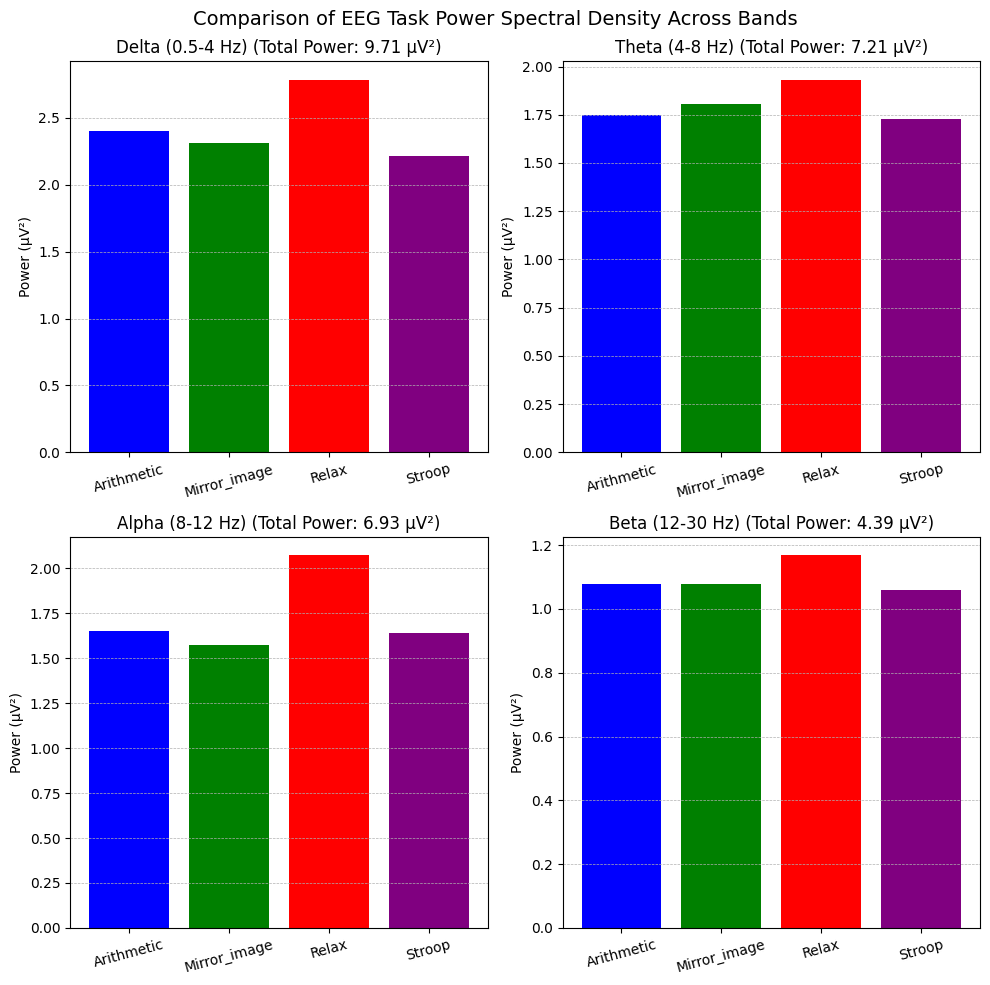

In [22]:
# Select which to use
selected_channels = task_channels  # relax_channels/task_channels

# Store average task power per band
total_band_power = {}
band_task_power = {band: {task: [] for task in tasks_list} for band in bands.keys()}

for band, (low, high) in bands.items():
    total_power = 0  # Reset total power for this band
    
    for task in tasks_list:
        subject_power = []

        for subject_number in subjects:
            trial_power = []

            for trial_number in trials:
                filename = f'{task}_sub_{subject_number}_trial{trial_number}.mat'
                path = f'./Data/filtered_data/{filename}'

                try:
                    file = loadmat(path)
                    eeg_data = file['Clean_data']
                    
                    selected_indices = [channel_names.index(ch) for ch in selected_channels]  # Find indices
                    eeg_data = eeg_data[selected_indices, :]  # Keep only relevant channels
                    
                    """
                    frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)  # Frequency associated to each FFT point
                    fft_data = np.fft.fft(eeg_data, axis=1)
                    power_spectrum = np.abs(fft_data)[: , :n_samples]                   
                    """

                    # Compute Power Spectral Density (PSD) using Welch's method
                    frequencies, psd = welch(eeg_data, fs=sampling_rate, axis=1, nperseg=n_samples // 2)
                    band_mask = (frequencies >= low) & (frequencies <= high)
                    # Compute mean power in the band
                    #mean_band_power = power_spectrum[:, band_mask].mean()
                    mean_band_power = psd[:, band_mask].mean()
                    trial_power.append(mean_band_power)

                except FileNotFoundError:
                    print(f"File {filename} not found. Skipping.")

            if trial_power:
                subject_power.append(np.mean(trial_power))

        if subject_power:
            mean_subject_power = np.mean(subject_power)
            band_task_power[band][task] = mean_subject_power
            total_power += mean_subject_power

    total_band_power[band] = total_power


# Step 8: Plot results (one subplot per frequency band)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Comparison of EEG Task Power Spectral Density Across Bands", fontsize=14)

colors = ['blue', 'green', 'red', 'purple']

for ax, (band, task_values) in zip(axes.flatten(), band_task_power.items()):
    total_power = total_band_power[band]
    ax.bar(tasks_list, list(task_values.values()), color=colors)
    ax.set_title(f"{band} (Total Power: {total_power:.2f} µV²)", fontsize=12)
    ax.set_ylabel("Power (µV²)")
    ax.set_xticks(range(len(tasks_list)))
    ax.set_xticklabels(tasks_list, rotation=15)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()



## ICA

### ICA with fast ICA from scikit-learn

In [23]:
from sklearn.decomposition import FastICA

#Bandpass Filter (0.5-40 Hz) to remove low-frequency drift and high-frequency noise
def bandpass_filter(data, lowcut=0.5, highcut=40, fs=128, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

def SKLFast_ICA(eeg_data, lda=6):
    filtered_eeg = bandpass_filter(eeg_data)

    # Apply ICA (Independent Component Analysis)
    ica = FastICA(n_components=n_channels, random_state=42)
    ica_sources = ica.fit_transform(filtered_eeg.T).T

    # Identify Artifacts (Heuristic: High Amplitude Components)
    artifact_indices = []
    for i in range(n_channels):
        if np.max(np.abs(ica_sources[i])) > lda * np.median(np.abs(ica_sources[i])):  # Threshold-based detection
            artifact_indices.append(i)

    print(f"Identified Artifact Components: {artifact_indices}")

    # Remove Artifacts by Zeroing Out Identified Components
    ica_sources[artifact_indices, :] = 0

    # Reconstruct EEG Data (Inverse ICA)
    cleaned_eeg = ica.inverse_transform(ica_sources.T).T
    
    return cleaned_eeg

c:\Users\gaspa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Identified Artifact Components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


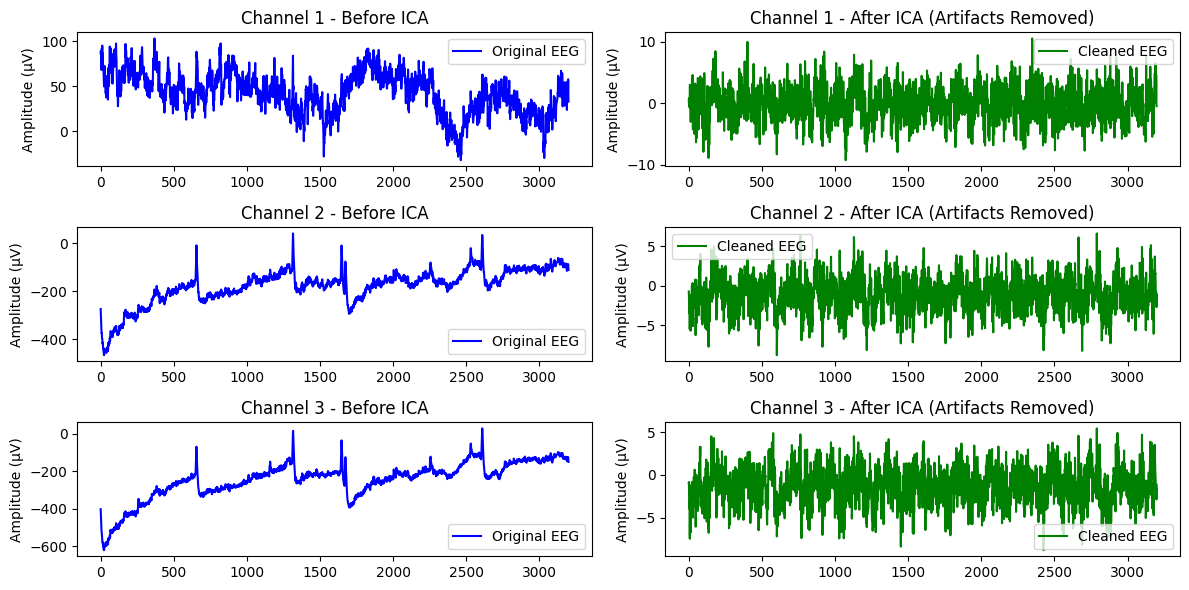

In [24]:

# Subject, Task, Trial (example)
subject_number = 1
task = "Arithmetic"
trial_number = 1
filename = f'{task}_sub_{subject_number}_trial{trial_number}.mat'
path = f'./Data/raw_data/{filename}'

# Load EEG Data
file = loadmat(path)
eeg_data = file['Data']

filtered_eeg = bandpass_filter(eeg_data)

# Apply ICA (Independent Component Analysis)
ica = FastICA(n_components=n_channels, random_state=42)
ica_sources = ica.fit_transform(filtered_eeg.T).T

# Identify Artifacts (Heuristic: High Amplitude Components)
artifact_indices = []
for i in range(n_channels):
    if np.max(np.abs(ica_sources[i])) > 6 * np.median(np.abs(ica_sources[i])):  # Threshold-based detection
        artifact_indices.append(i)

print(f"Identified Artifact Components: {artifact_indices}")

# Remove Artifacts by Zeroing Out Identified Components
ica_sources[artifact_indices, :] = 0

# Reconstruct EEG Data (Inverse ICA)
cleaned_eeg = ica.inverse_transform(ica_sources.T).T

# Plot Before/After ICA for a Few Channels
plt.figure(figsize=(12, 6))
for i in range(3):  # Plot 3 random channels
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(eeg_data[i, :], label="Original EEG", color="blue")
    plt.title(f"Channel {i+1} - Before ICA")
    plt.ylabel("Amplitude (µV)")
    plt.legend()

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(cleaned_eeg[i, :], label="Cleaned EEG", color="green")
    plt.title(f"Channel {i+1} - After ICA (Artifacts Removed)")
    plt.ylabel("Amplitude (µV)")
    plt.legend()

plt.tight_layout()
plt.show()


### Matlab code inspirated ICA

In [25]:
def matlab_like_cleaning(eeg_data, polyorder=5, window_length=127, wavelet='db2', level=4):
    """
    Translation of MATLAB EEG cleaning using Savitzky-Golay filter and wavelet thresholding.
    
    Parameters:
        eeg_data: np.ndarray, shape (channels, samples)
        polyorder: int, polynomial order for Savitzky-Golay filter
        window_length: int, window length for Savitzky-Golay filter
        wavelet: str, wavelet type for decomposition
        level: int, decomposition level
    
    Returns:
        clean_data: np.ndarray, cleaned EEG signals
    """
    num_channels, num_samples = eeg_data.shape
    cancelled = np.zeros_like(eeg_data)
    clean_data = np.zeros_like(eeg_data)

    # Step 1: Subtracting the trend using Savitzky-Golay filter
    for ch in range(num_channels):
        primary = eeg_data[ch, :]
        trend = savgol_filter(primary, window_length, polyorder)
        cancelled[ch, :] = primary - trend

    # Step 2: Wavelet thresholding
    for ch in range(num_channels):
        # Wavelet decomposition
        coeffs = pywt.wavedec(cancelled[ch, :], wavelet, level=level)
        approx = coeffs[0]
        details = coeffs[1:]

        # Threshold based on the standard deviation of detail coefficients (level 3)
        t = np.std(details[2]) * 0.8

        # Apply thresholding to approximation and details
        approx = np.sign(approx) * np.minimum(np.abs(approx), t)
        details = [np.sign(cd) * np.minimum(np.abs(cd), t) for cd in details]

        # Reconstruct the signal
        coeffs = [approx] + details
        clean = pywt.waverec(coeffs, wavelet)
        
        # Truncate to original length in case of padding during wavelet processing
        clean_data[ch, :] = clean[:num_samples]

    return clean_data


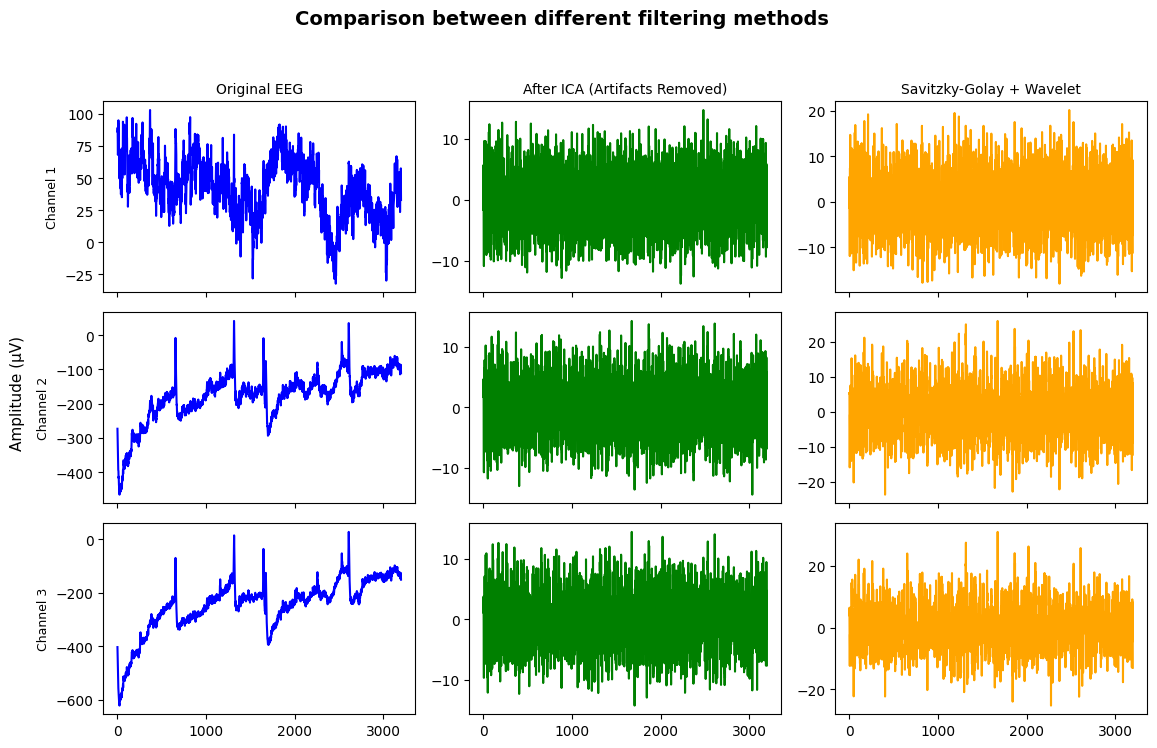

In [31]:
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Subject, Task, Trial (example)
subject_number = 1
task = "Arithmetic"
trial_number = 1
filename = f'{task}_sub_{subject_number}_trial{trial_number}.mat'
path = f'./Data/raw_data/{filename}'

# Load EEG Data
file = loadmat(path)
eeg_data = file['Data']

# Apply cleaning
cleaned_data = matlab_like_cleaning(eeg_data)
matlab_cleaned_data = loadmat(f'./Data/filtered_data/{filename}')['Clean_data']

# --- PLOTTING SECTION ---

fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True)
fig.suptitle("Comparison between different filtering methods", fontsize=14, weight='bold')

titles = [
    "Original EEG",
    "After ICA (Artifacts Removed)",
    "Savitzky-Golay + Wavelet"
]

for i in range(3):  # 3 channels
    # Original
    axes[i, 0].plot(eeg_data[i, :], color="blue")
    axes[i, 0].set_title(titles[0] if i == 0 else "", fontsize=10)
    axes[i, 0].set_ylabel(f"Channel {i+1}", fontsize=9)

    # Cleaned (ICA)
    axes[i, 1].plot(cleaned_data[i, :], color="green")
    axes[i, 1].set_title(titles[1] if i == 0 else "", fontsize=10)

    # Matlab cleaned (Savitzky-Golay + Wavelet)
    axes[i, 2].plot(matlab_cleaned_data[i, :], color="orange")
    axes[i, 2].set_title(titles[2] if i == 0 else "", fontsize=10)

# Label global sur la gauche
fig.text(0.04, 0.5, 'Amplitude (µV)', va='center', rotation='vertical', fontsize=11)

# Espacement propre
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


### Matlab improved code

In [27]:
import mne

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    """Band-pass filter for EEG signal."""
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    return filtfilt(b, a, signal)

def wavelet_denoising(signal, wavelet='db4', level=4):
    """Wavelet denoising with adaptive thresholding."""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Noise estimation
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    denoised_coeffs = [coeffs[0]]  # Keep approximation coefficients
    for detail_coeff in coeffs[1:]:
        denoised_detail = pywt.threshold(detail_coeff, threshold, mode='soft')
        denoised_coeffs.append(denoised_detail)

    return pywt.waverec(denoised_coeffs, wavelet)

def modern_cleaning(eeg_data, sfreq=128):
    """
    Optimized EEG cleaning: band-pass filter, ICA, and wavelet denoising.
    
    eeg_data: np.ndarray (channels, samples)
    sfreq: Sampling frequency (Hz)
    
    Returns:
        cleaned_data: np.ndarray (channels, samples)
    """

    n_channels, n_times = eeg_data.shape
    ch_names = [f"EEG {i+1}" for i in range(n_channels)]
    ch_types = ['eeg'] * n_channels

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(eeg_data, info)

    raw.filter(1., 40., fir_design='firwin')

    ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter='auto')
    ica.fit(raw)

    # Comment out automatic artifact detection (no EOG channels)
    # eog_inds, scores = ica.find_bads_eog(raw)
    # ecg_inds, scores = ica.find_bads_ecg(raw)
    # ica.exclude = eog_inds + ecg_inds

    # Optional: manual exclusion after visualization
    # ica.plot_components()
    # ica.exclude = [0, 1]  # Example if needed

    raw_clean = raw.copy()
    ica.apply(raw_clean)

    cleaned_data = raw_clean.get_data()
    for ch in range(n_channels):
        cleaned_data[ch, :] = wavelet_denoising(cleaned_data[ch, :])

    return cleaned_data


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


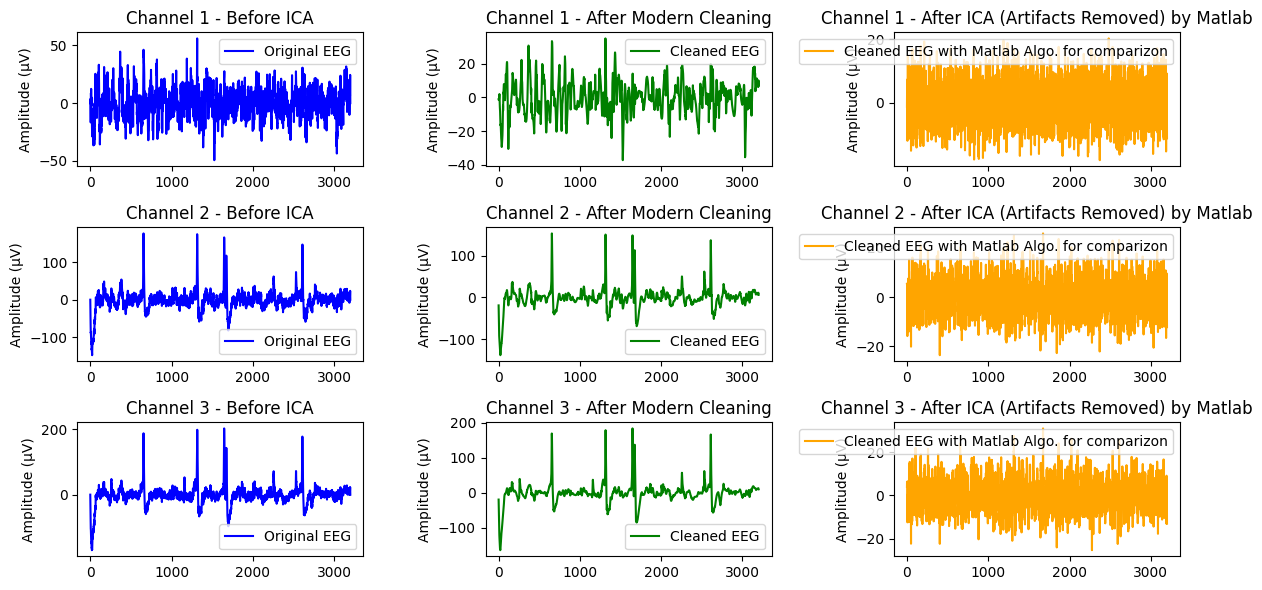

In [28]:
# Subject, Task, Trial (example)
subject_number = 1
task = "Arithmetic"
trial_number = 1
filename = f'{task}_sub_{subject_number}_trial{trial_number}.mat'
path = f'./Data/raw_data/{filename}'

# Load EEG Data
file = loadmat(path)
eeg_data = file['Data']


# Apply cleaning
cleaned_data = modern_cleaning(eeg_data)
matlab_cleaned_data = loadmat(f'./Data/filtered_data/{filename}')['Clean_data']

# Plot Before/After ICA for a Few Channels
plt.figure(figsize=(12, 6))
for i in range(3):  # Plot 3 random channels
    plt.subplot(3, 3, 3 * i + 1)
    plt.plot(eeg_data[i, :], label="Original EEG", color="blue")
    plt.title(f"Channel {i+1} - Before ICA")
    plt.ylabel("Amplitude (µV)")
    plt.legend()

    plt.subplot(3, 3, 3 * i + 2)
    plt.plot(cleaned_data[i, :], label="Cleaned EEG", color="green")
    plt.title(f"Channel {i+1} - After Modern Cleaning")
    plt.ylabel("Amplitude (µV)")
    plt.legend()


    plt.subplot(3, 3, 3 * i + 3)
    plt.plot(matlab_cleaned_data[i, :], label="Cleaned EEG with Matlab Algo. for comparizon", color="orange")
    plt.title(f"Channel {i+1} - After ICA (Artifacts Removed) by Matlab")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    
plt.tight_layout()
plt.show()


## Spectral Analysis

Already done, to confirm.

# 4. Setup the Development Environment

Done.